In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/leaf-test-validate-train/Niphad Grape Leaf Disease Dataset (NGLD)/Grapes Disease Dataset test/Powdery Mildew/Powdery Mildew_28.jpg
/kaggle/input/leaf-test-validate-train/Niphad Grape Leaf Disease Dataset (NGLD)/Grapes Disease Dataset test/Powdery Mildew/Powdery Mildew_17.jpg
/kaggle/input/leaf-test-validate-train/Niphad Grape Leaf Disease Dataset (NGLD)/Grapes Disease Dataset test/Powdery Mildew/Powdery Mildew_31.jpg
/kaggle/input/leaf-test-validate-train/Niphad Grape Leaf Disease Dataset (NGLD)/Grapes Disease Dataset test/Powdery Mildew/Powdery Mildew_39.jpg
/kaggle/input/leaf-test-validate-train/Niphad Grape Leaf Disease Dataset (NGLD)/Grapes Disease Dataset test/Powdery Mildew/Powdery Mildew_48.jpg
/kaggle/input/leaf-test-validate-train/Niphad Grape Leaf Disease Dataset (NGLD)/Grapes Disease Dataset test/Powdery Mildew/Powdery Mildew_32.jpg
/kaggle/input/leaf-test-validate-train/Niphad Grape Leaf Disease Dataset (NGLD)/Grapes Disease Dataset test/Powdery Mildew/Powdery

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from skimage import exposure, color
from skimage.restoration import denoise_tv_chambolle

2025-07-02 06:12:47.163643: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751436767.397597      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751436767.473047      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import os

# Define paths
train_dir = "/kaggle/input/leaf-test-validate-train/Niphad Grape Leaf Disease Dataset (NGLD)/Grapes Disease Dataset train"
validation_dir = "/kaggle/input/leaf-test-validate-train/Niphad Grape Leaf Disease Dataset (NGLD)/Grapes Disease Dataset test"
test_dir = "/kaggle/input/leaf-test-validate-train/Niphad Grape Leaf Disease Dataset (NGLD)/Grapes Disease Dataset validate"


# List classes (assuming folder names represent classes)
classes = os.listdir(train_dir)
print("Classes:", classes)

Classes: ['Powdery Mildew', 'Bacterial Leaf Spot', 'Downy Mildew', 'Healthy Leaves']


Train counts: {'Powdery Mildew': 406, 'Bacterial Leaf Spot': 85, 'Downy Mildew': 967, 'Healthy Leaves': 1254}
Validation counts: {'Powdery Mildew': 61, 'Bacterial Leaf Spot': 15, 'Downy Mildew': 146, 'Healthy Leaves': 188}
Test counts: {'Powdery Mildew': 61, 'Bacterial Leaf Spot': 15, 'Downy Mildew': 146, 'Healthy Leaves': 188}


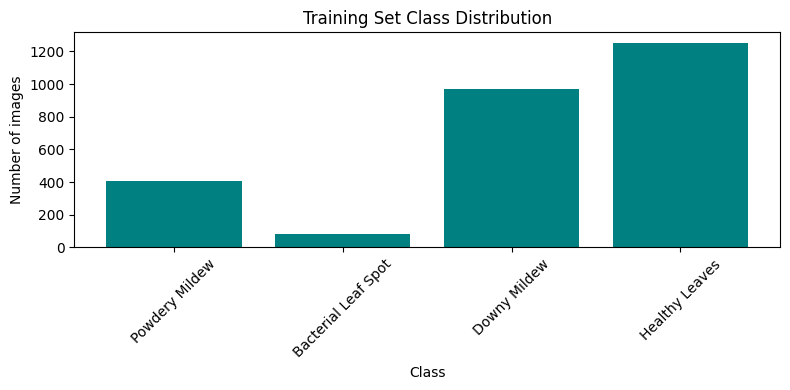

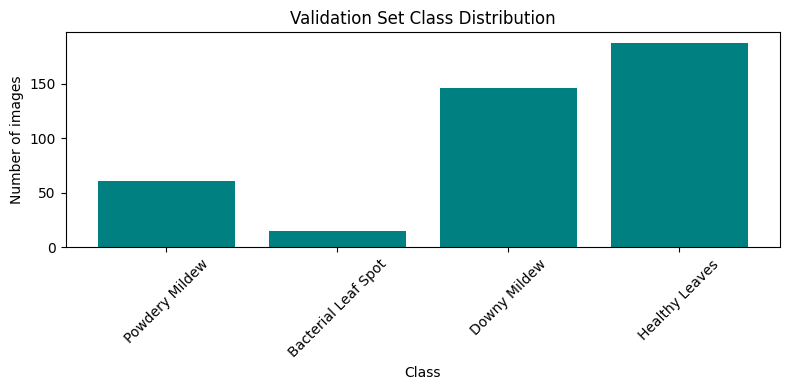

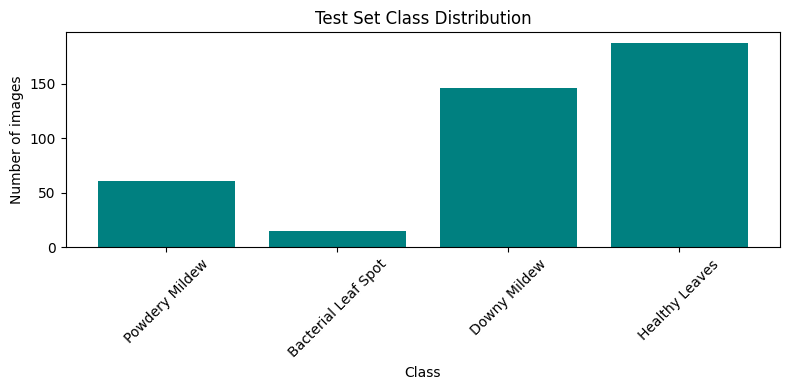

In [4]:
import os
import matplotlib.pyplot as plt

# Define paths
train_dir = "/kaggle/input/leaf-test-validate-train/Niphad Grape Leaf Disease Dataset (NGLD)/Grapes Disease Dataset train"
validation_dir = "/kaggle/input/leaf-test-validate-train/Niphad Grape Leaf Disease Dataset (NGLD)/Grapes Disease Dataset test"
test_dir = "/kaggle/input/leaf-test-validate-train/Niphad Grape Leaf Disease Dataset (NGLD)/Grapes Disease Dataset validate"

# Function to count images per class
def count_images_per_class(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            num_images = len([
                file for file in os.listdir(class_path)
                if os.path.isfile(os.path.join(class_path, file))
            ])
            class_counts[class_name] = num_images
    return class_counts

# Count images
train_counts = count_images_per_class(train_dir)
val_counts = count_images_per_class(validation_dir)
test_counts = count_images_per_class(test_dir)

# Print counts
print("Train counts:", train_counts)
print("Validation counts:", val_counts)
print("Test counts:", test_counts)

# Plotting
def plot_counts(counts, title):
    plt.figure(figsize=(8, 4))
    plt.bar(counts.keys(), counts.values(), color='teal')
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Number of images")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_counts(train_counts, "Training Set Class Distribution")
plot_counts(val_counts, "Validation Set Class Distribution")
plot_counts(test_counts, "Test Set Class Distribution")


In [5]:
import cv2
import numpy as np
from PIL import Image
from tqdm import tqdm

def preprocess_image(image_path, target_size=(224, 224)):
    """
    Preprocess an image by resizing, removing noise, and normalizing.
    """
    # Read image
    img = cv2.imread(image_path)

    # Convert to grayscale for noise removal
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply GaussianBlur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply Otsu's thresholding to remove background
    _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Invert the mask to keep the leaf
    mask = 255 - thresh

    # Apply the mask to the original image
    result = cv2.bitwise_and(img, img, mask=mask)

    # Resize the image
    resized = cv2.resize(result, target_size)

    # Normalize pixel values
    normalized = resized / 255.0

    return normalized

def preprocess_dataset(dataset_dir, target_size=(224, 224)):
    """
    Preprocess all images in a dataset directory.
    """
    preprocessed_data = []
    labels = []

    for class_name in os.listdir(dataset_dir):
        class_dir = os.path.join(dataset_dir, class_name)
        if not os.path.isdir(class_dir):
            continue

        for filename in tqdm(os.listdir(class_dir), desc=f"Processing {class_name}"):
            if filename.endswith(('.jpg', '.jpeg', '.png')):
                image_path = os.path.join(class_dir, filename)
                try:
                    preprocessed_img = preprocess_image(image_path, target_size)
                    preprocessed_data.append(preprocessed_img)
                    labels.append(class_name)
                except Exception as e:
                    print(f"Error processing {image_path}: {e}")

    return np.array(preprocessed_data), labels

# Preprocess training data
X_train, y_train = preprocess_dataset(train_dir)
print("Training data shape:", X_train.shape)

# Preprocess validation data
X_val, y_val = preprocess_dataset(validation_dir)
print("Validation data shape:", X_val.shape)

# Preprocess test data
X_test, y_test = preprocess_dataset(test_dir)
print("Test data shape:", X_test.shape)

Processing Healthy Leaves: 100%|██████████| 1254/1254 [00:08<00:00, 149.16it/s]


Training data shape: (2650, 224, 224, 3)


Processing Healthy Leaves: 100%|██████████| 188/188 [00:01<00:00, 148.05it/s]


Validation data shape: (404, 224, 224, 3)


Processing Healthy Leaves: 100%|██████████| 188/188 [00:01<00:00, 153.69it/s]


Test data shape: (404, 224, 224, 3)


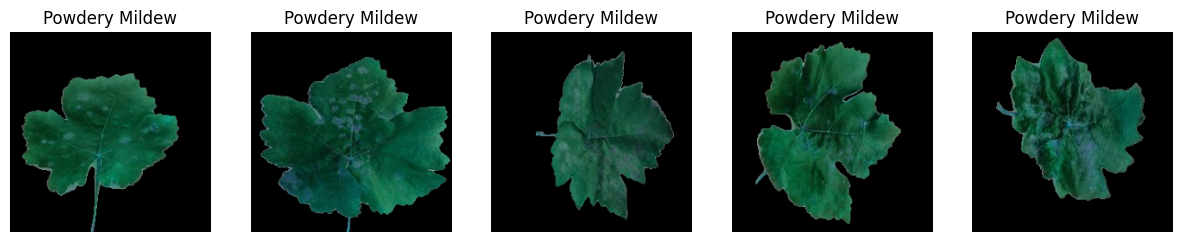

In [6]:
import matplotlib.pyplot as plt

def display_sample_images(images, labels, num_samples=5):
    """
    Display sample images with their labels.
    """
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[i])
        plt.title(labels[i])
        plt.axis('off')
    plt.show()

# Display sample training images
display_sample_images(X_train, y_train)

In [7]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

label_encoder = LabelEncoder()

# Combine all label sets for fitting
all_labels = np.concatenate([y_train, y_val, y_test])
label_encoder.fit(all_labels)

# Then transform individually
y_train_encoded = label_encoder.transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# One-hot encode labels
num_classes = len(classes)
y_train_onehot = to_categorical(y_train_encoded, num_classes)
y_val_onehot = to_categorical(y_val_encoded, num_classes)
y_test_onehot = to_categorical(y_test_encoded, num_classes)

# Build CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train, y_train_onehot,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val_onehot)
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-07-02 06:13:32.894832: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - accuracy: 0.5287 - loss: 1.0720 - val_accuracy: 0.7797 - val_loss: 0.6651
Epoch 2/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step - accuracy: 0.8108 - loss: 0.5301 - val_accuracy: 0.9307 - val_loss: 0.2715
Epoch 3/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - accuracy: 0.9081 - loss: 0.2798 - val_accuracy: 0.9703 - val_loss: 0.1667
Epoch 4/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.9364 - loss: 0.1849 - val_accuracy: 0.9827 - val_loss: 0.0955
Epoch 5/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.9709 - loss: 0.1067 - val_accuracy: 0.9926 - val_loss: 0.0471
Epoch 6/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.9778 - loss: 0.0658 - val_accuracy: 0.9876 - val_loss: 0.0559
Epoch 7/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.9743 - loss: 0.0693 - val_accuracy: 0.9950 - val_loss: 0.0445
Epoch 8/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 207s 2s/step - accuracy: 0.9925 - loss: 0.0265 - val_accuracy: 0.9926 - v

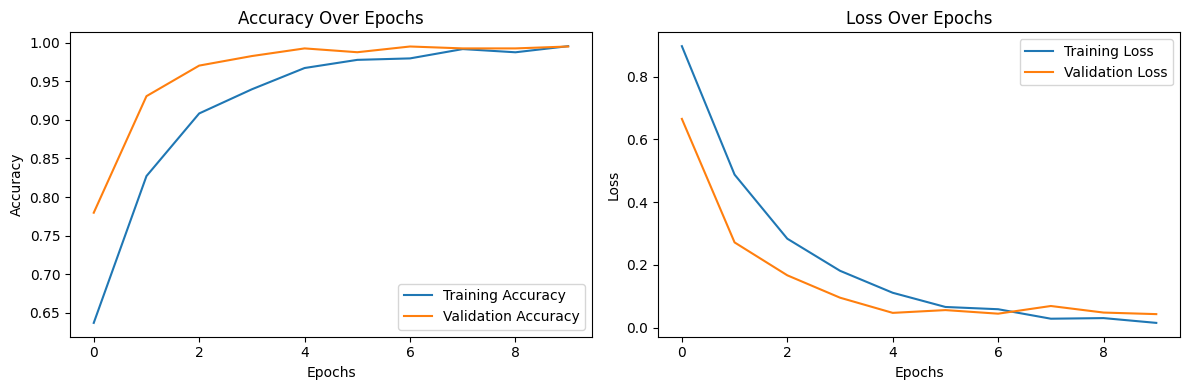

In [9]:
import matplotlib.pyplot as plt

# Plot training history
def plot_training_history(history):
    """
    Plot accuracy and loss over epochs.
    """
    plt.figure(figsize=(12, 4))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [10]:
# Evaluate the model on validation data
val_loss, val_accuracy = model.evaluate(X_val, y_val_onehot)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 476ms/step - accuracy: 0.9910 - loss: 0.0776
Validation Loss: 0.0431
Validation Accuracy: 0.9950


In [11]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predict on test data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 473ms/step


In [12]:
import numpy as np
unique_classes = np.unique(y_test_encoded)
print("Detected encoded classes:", unique_classes)


Detected encoded classes: [0 1 2 3]


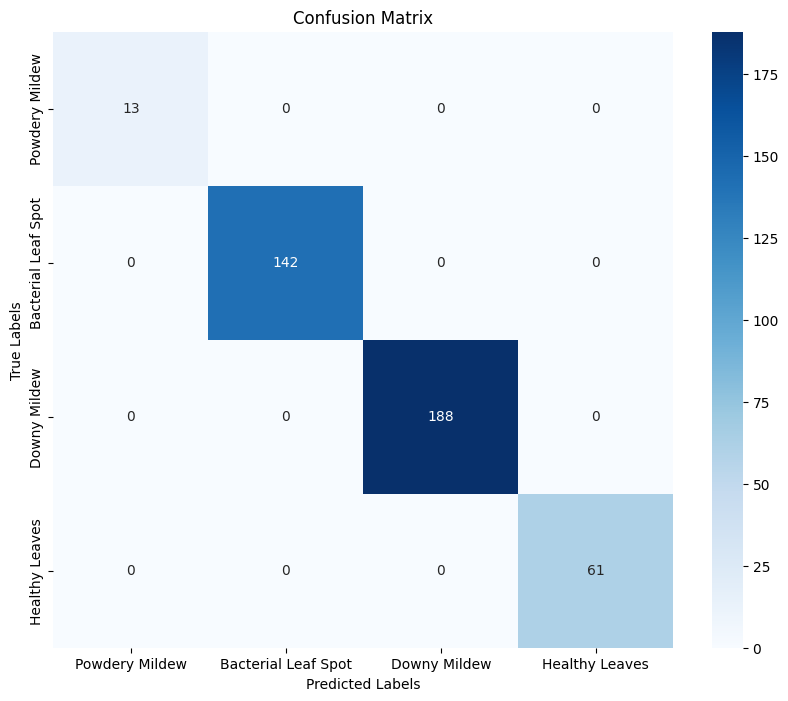

In [13]:



# Generate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [14]:
# Save the model
model.save('/content/drive/MyDrive/models/leaf_classifier.h5')

# Load the model
from tensorflow.keras.models import load_model

loaded_model = load_model('/content/drive/MyDrive/models/leaf_classifier.h5')
print("Model loaded successfully.")

Model loaded successfully.
